In [120]:
%%time

import os
import boto3
import re  # regular  expression  library 
import sagemaker
import sklearn
import numpy as np
import time
import matplotlib.pyplot as plt

from time import gmtime, strftime

# Get a SageMaker-compatible role used by this Notebook Instance.
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

### update below values appropriately ###
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-classification-diabete'
#### 

print(region)
print(bucket)
print(role)

us-east-1
sagemaker-us-east-1-861737859161
arn:aws:iam::861737859161:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
CPU times: user 92 ms, sys: 3.79 ms, total: 95.8 ms
Wall time: 220 ms


In [88]:
%%time

import io
import boto3
import random

def data_split(FILE_DATA, DATA_DIR, FILE_TRAIN_BASE, FILE_TRAIN_1, FILE_VALIDATION, FILE_TEST, 
               PERCENT_TRAIN_0, PERCENT_TRAIN_1, PERCENT_VALIDATION, PERCENT_TEST):
    data = [l for l in open(FILE_DATA, 'r')]
    train_file_0 = open(DATA_DIR + "/" + FILE_TRAIN_0, 'w')
    train_file_1 = open(DATA_DIR + "/" + FILE_TRAIN_1, 'w')
    valid_file = open(DATA_DIR + "/" + FILE_VALIDATION, 'w')
    tests_file = open(DATA_DIR + "/" + FILE_TEST, 'w')

    num_of_data = len(data)
    num_train_0 = int((PERCENT_TRAIN_0/100.0)*num_of_data)
    num_train_1 = int((PERCENT_TRAIN_1/100.0)*num_of_data)
    num_valid = int((PERCENT_VALIDATION/100.0)*num_of_data)
    num_tests = int((PERCENT_TEST/100.0)*num_of_data)

    data_fractions = [num_train_0, num_train_1, num_valid, num_tests]
    split_data = [[],[],[],[]]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_fractions):
        for i in range(fraction):
            rand_data_ind = random.randint(0, len(data)-1)
            split_data[split_ind].append(data[rand_data_ind])
            data.pop(rand_data_ind)

    for l in split_data[0]:
        train_file_0.write(l)

    for l in split_data[1]:
        train_file_1.write(l)
        
    for l in split_data[2]:
        valid_file.write(l)

    for l in split_data[3]:
        tests_file.write(l)

    train_file_0.close()
    train_file_1.close()
    valid_file.close()
    tests_file.close()

def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 26.7 µs


In [89]:
%%time

from sklearn.datasets import load_svmlight_file

s3 = boto3.client("s3")

# Load the dataset
FILE_DATA_0RIG = 'diabete'

s3.download_file("sagemaker-sample-files-erasolon", f"datasets/classification/diabete.libsvm", FILE_DATA_0RIG)
data = load_svmlight_file(FILE_DATA_0RIG)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 108 ms


In [90]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data[1])
labels = le.transform(data[1])

In [91]:
from sklearn.datasets import dump_svmlight_file

LABELED_FILE = FILE_DATA_0RIG +"_labeled.libsvm"

dump_svmlight_file(data[0], labels, LABELED_FILE)
s3.upload_file(LABELED_FILE, bucket , "datasets/classification/" + LABELED_FILE )

In [92]:
# Load the dataset
FILE_DATA = FILE_DATA_0RIG + '_labeled'
s3.download_file(bucket, "datasets/classification/" + LABELED_FILE, FILE_DATA)

#split the downloaded data into train/test/validation files
FILE_TRAIN_0 = FILE_DATA + '.train_0'
FILE_TRAIN_1 = FILE_DATA + '.train_1'
FILE_VALIDATION = FILE_DATA + '.validation'
FILE_TEST = FILE_DATA + '.test'
PERCENT_TRAIN_0 = 35
PERCENT_TRAIN_1 = 35
PERCENT_VALIDATION = 15
PERCENT_TEST = 15

DATA_DIR = 'data'

if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

data_split(FILE_DATA, DATA_DIR, FILE_TRAIN_0, FILE_TRAIN_1, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN_0, PERCENT_TRAIN_1, PERCENT_VALIDATION, PERCENT_TEST)

In [93]:
#upload the files to the S3 bucket
upload_to_s3(bucket, 'train/train_0.libsvm', DATA_DIR + "/" + FILE_TRAIN_0)
upload_to_s3(bucket, 'train/train_1.libsvm', DATA_DIR + "/" + FILE_TRAIN_1)
upload_to_s3(bucket, 'validation/validation.libsvm', DATA_DIR + "/" + FILE_VALIDATION)
upload_to_s3(bucket, 'test/test.libsvm', DATA_DIR + "/" + FILE_TEST)

Writing to s3://sagemaker-us-east-1-861737859161/sagemaker/DEMO-xgboost-classification-diabete/train/train_0.libsvm/data/diabete_labeled.train_0
Writing to s3://sagemaker-us-east-1-861737859161/sagemaker/DEMO-xgboost-classification-diabete/train/train_1.libsvm/data/diabete_labeled.train_1
Writing to s3://sagemaker-us-east-1-861737859161/sagemaker/DEMO-xgboost-classification-diabete/validation/validation.libsvm/data/diabete_labeled.validation
Writing to s3://sagemaker-us-east-1-861737859161/sagemaker/DEMO-xgboost-classification-diabete/test/test.libsvm/data/diabete_labeled.test


In [94]:
hyperparams = {
        "max_depth": "5",
        "num_class": len(le.classes_),
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.7",
        "objective": "multi:softmax",
        "num_round": "50",
        "eval_metric": "merror",
        "verbosity":"2",
}

instance_type = "ml.m5.2xlarge"
output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, FILE_DATA + '-dist-xgb')
content_type = "libsvm"

In [95]:
# Built-in based xgboost
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
xgb_script_mode_estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparams,
                                          role=role,
                                          instance_count=2, 
                                          instance_type=instance_type,
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

train_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, "train"), content_type=content_type)
validation_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, "validation"),content_type=content_type)

In [96]:
# Training without hypertuning 
#xgb_script_mode_estimator.fit({'train': train_input, 'validation': validation_input})

## HYPERPARAMETER TUNING

In [101]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':IntegerParameter(0, 5,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': IntegerParameter(0,10,scaling_type='Auto'),
    'num_round': IntegerParameter(1,4000,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic'),
}

objective_metric_name = 'validation:f1'
objective_type = 'Maximize'

tuner_log = HyperparameterTuner(
    xgb_script_mode_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    base_tuning_job_name= 'diabete-clf-tuning',
    objective_type = objective_type,
    max_jobs=5,
    max_parallel_jobs=5,
)

## Starts the hyperparameter tuning job
tuner_log.fit({'train': train_input, 'validation': validation_input}, include_cls_metadata=False, wait=False)

tuning_job_name = tuner_log.latest_tuning_job.name

## Prints the status of the latest hyperparameter tuning job
status = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(60)
    status = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']
    print(status)

InProgress
InProgress
InProgress
InProgress
InProgress
Completed


In [99]:
# In case there is a need to stop the tuning job
#tuner_log.stop_tuning_job()

In [102]:
job_name = tuner_log.best_training_job()
print(job_name)

diabete-clf-tuning-210515-1359-002-46ce30e2


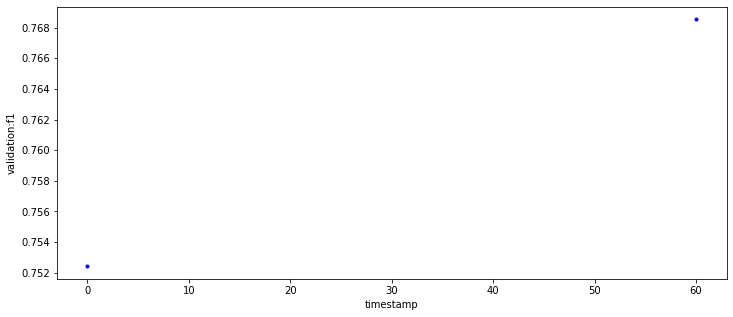

In [108]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

metric_name = "validation:f1"

metrics_dataframe = TrainingJobAnalytics(
    training_job_name=job_name, metric_names=[metric_name]
).dataframe()
plt = metrics_dataframe.plot(
    kind="line", figsize=(12, 5), x="timestamp", y="value", style="b.", legend=False
)
plt.set_ylabel(metric_name);

In [109]:
attached_tuner = HyperparameterTuner.attach(tuning_job_name)
predictor = attached_tuner.deploy(initial_instance_count=1, instance_type="ml.m5.2xlarge")


2021-05-15 14:03:54 Starting - Preparing the instances for training
2021-05-15 14:03:54 Downloading - Downloading input data
2021-05-15 14:03:54 Training - Training image download completed. Training in progress.
2021-05-15 14:03:54 Uploading - Uploading generated training model
2021-05-15 14:03:54 Completed - Training job completed
-------------!

In [110]:
test_file = DATA_DIR + "/" + FILE_TEST
with open(test_file, 'r') as f:
    payload = f.read()

In [111]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)
response = runtime_client.invoke_endpoint(EndpointName=predictor.endpoint_name, 
                                          ContentType='text/libsvm', 
                                          Body=payload)
result = response['Body'].read().decode('ascii')
print('Predicted values are {}.'.format(result))

Predicted values are 1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0.


In [112]:
y_pred = np.fromstring(result.replace("[","").replace("]",""), dtype=float, sep=',')

In [113]:
from sklearn.datasets import load_svmlight_file

data_true = load_svmlight_file(test_file)
y_true = data_true[1]

In [114]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.57      0.62        37
         1.0       0.81      0.87      0.84        78

    accuracy                           0.77       115
   macro avg       0.74      0.72      0.73       115
weighted avg       0.77      0.77      0.77       115



In [118]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred)

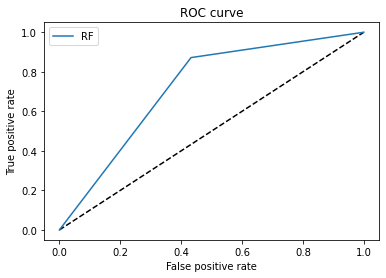

In [121]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [122]:
predictor.delete_endpoint()